# An Exact Riemann solver for 1D Euler equation

In [11]:
√0.005

0.07071067811865475

## Governing Equation
The governing equation for the Riemann problem is the Euler equations

$$ \mathbf{U}_t+\mathbf{F}(\mathbf{U})_x = 0$$

where 

$$\mathbf{U} = \left[ \begin{align}
\rho\\
\rho u\\ 
E\\ 
\end{align} 
\right]
$$, $$
\mathbf{F} = \left[ \begin{align}
\rho u\\ \rho u^2+p\\ u(E+p)\\ 
\end{align} \right] $$

with initial conditions of

$$ \mathbf{U}(x,0) = \mathbf{U}^{(0)}(x)
= \left\{ \begin{align} 
\mathbf{U}_L,\quad \text{if} \quad x<0, \\
\mathbf{U}_R,\quad \text{if} \quad x>0, \\
\end{align} \right.
$$

And the EOS is

$$ e = \frac{p}{(\gamma-1)\rho}$$.


In [12]:
struct W
    ρ::Float64
    u::Float64
    p::Float64
end

## Solving method

In the Star region, we establish a function of the pressure $p^*$ with the velocity $u^*$ on left and right sepratively.
### Left function 
$$f_L(p, \mathbf{W}_L) = \left\{ \begin{align} 
(p-p_L)\left[\frac{A_L}{p+B_L}\right]^{1/2} \quad \text{if} \quad p>p_L \quad \text(shock),\\
\frac{2a_L}{\gamma -1} \left[ \left(\frac{p}{p_L}\right)^{\frac{\gamma-1}{2\gamma}} -1\right] \quad \text{if} \quad p\le p_L \quad \text{(rarefaction)}
\end{align} \right.
$$
and the data-dependent constants $A_L, B_L, A_R,B_R$ are given by
$$ \left. \begin{array}{ll}
      A_L = \frac{2}{(\gamma+1)\rho_L},& B_L = \frac{(\gamma -1)}{(\gamma +1)}p_L,\\
      A_R = \frac{2}{(\gamma+1)\rho_R},& B_R = \frac{(\gamma -1)}{(\gamma +1)}p_R,\\
      \end{array}\right\} $$

In [13]:
function f(p::Float64,W₀::W,γ::Float64)
    ρ₀,u₀,p₀ = W₀.ρ,W₀.u,W₀.p
    
    A = 2/((γ +1 )*ρ₀)
    B = (γ-1)/(γ+1)*p₀
    
    if p>p₀ 
        return (p-p₀)*√(A/(p+B))
    else
        a₀ = √(γ*p₀/ρ₀)
        return 2a₀/(γ-1)*((p/p₀)^((γ-1)/2/γ) -1)
    end
end    

f (generic function with 1 method)

$$\rho_L^* = \rho_L(p^*/p_L)^{1/\gamma}$$
$$u^* = u_L -f_L(p^*,W_L)$$

$$\rho_R^* = \rho_R(p^*/p_R)^{1/\gamma}$$
$$u^* = u_R +f_R(p^*,W_R)$$

In [14]:
function ρₚ(p::Float64,W₀::W,γ::Float64)
    if p < W₀.p
       return W₀.ρ*(p/W₀.p)^(1/γ)
    else 
        return W₀.ρ*((γ-1)/(γ+1)+p/W₀.p)/((γ-1)/(γ+1)*p/W₀.p+1)
    end
end

ρₚ (generic function with 1 method)

In [15]:
function Derivative(f::Function,x::Float64)
    ϵ₀ = 1e-10
    if abs(x) >= ϵ₀
        ϵ= ϵ₀*x
    else
        ϵ =ϵ₀
    end
    f¹(x) = (f(x+ϵ)-f(x))/ϵ
    return f¹(x)
end

Derivative (generic function with 1 method)

In [16]:
    fₗ(p) = f(p,Wₗ,γ)
    fᵣ(p) = f(p,Wᵣ,γ)
    F(p) = fₗ(p) + fᵣ(p)+Wᵣ.u-Wₗ.u
    F¹(p) = Derivative(p->F(p),p)

F¹ (generic function with 1 method)

## Newton iteration 

We use the Newton iteration method to solve
$$f_L(p) +f_R(p)+ u_R-u_L = 0$$

In [34]:
function RiemannSolver(Wₗ::W,Wᵣ::W,γ::Float64)    
   #     γ = 1.4
     p = (Wₗ.p + Wᵣ.p)/2
     TOL = 1.0e-4
   #  i = 1
    
    ϵ = 1.0e-8
    
    WₗStar = W(ϵ,0,ϵ)
    WᵣStar = W(ϵ,0,ϵ)
    
     aₗ = √(γ*Wₗ.p/Wₗ.ρ) 
     aᵣ = √(γ*Wᵣ.p/Wᵣ.ρ) 
     cri = aₗ/(γ-1) + aᵣ/(γ-1) +Wₗ.u-Wᵣ.u
    
    if cri >0
        while true 
            F₁ = F(p)
             p1 = p- F₁/F¹(p)
             if max(abs(F₁),2*abs(p1-p)/(p1+p)) < TOL
                break
            end 
        #    i += 1
            p=max(p1,TOL)
         #   @show p,F₁  
        end

        pStar = p
        uStar = Wₗ.u-fₗ(p)
        ρₗStar = ρₚ(p,Wₗ,γ)
        ρᵣStar = ρₚ(p,Wᵣ,γ)
        WₗStar = W(ρₗStar,uStar,pStar)
        WᵣStar = W(ρᵣStar,uStar,pStar)
    end
    
    return WₗStar,WᵣStar
end

RiemannSolver (generic function with 1 method)

### A complete result
After Solving the states in the star regions, if we want to get a detailed ditribution, we can use the following function.


In [22]:
function SolveDistr(t::Float64,Wₗ::W,Wᵣ::W,γ::Float64)
    
    WₗStar,WᵣStar = RiemannSolver(Wₗ,Wᵣ,γ)
    
    ρₗStar,uStar, pStar =WₗStar.ρ,WₗStar.u,WₗStar.p
    ρᵣStar = WᵣStar.ρ
    ρₗ,pₗ,uₗ = Wₗ.ρ,Wₗ.p,Wₗ.u
    ρᵣ,pᵣ,uᵣ = Wᵣ.ρ,Wᵣ.p,Wᵣ.u
    
    I = 1200
    U = zeros(Float64,(I,3))
    x = zeros(Float64,I)
    if pStar > pₗ  # Left shock
        sL = (ρₗStar*uStar - ρₗ*uₗ)/(ρₗStar-ρₗ)
        for i =1:200
            x[i] = (2-0.005*(i-1))*sL*t
            U[i,:] = [ρₗ,uₗ,pₗ]
        end
        for i = 201:600
            x[i] = ((uStar-sL)/400*(i-200) + sL)*t
            U[i,:] = [ρₗStar,uStar,pStar]
        end
    else  # Left Rarefaction
        cL = √(γ*pₗ/ρₗ)
        cLStar = √(γ*pStar/ρₗStar)
        sLSlow = uₗ - cL
        sLFast = uStar - cLStar
        for i = 1:200
            x[i] =(2-0.005*(i-1))*sLSlow*t
            U[i,:] = [ρₗ,uₗ,pₗ]
        end
        
        x[201:400],U[201:400,:] = RareSpeedToU(t,Wₗ,pStar,γ,1)
        for i =401:600
            x[i] = ((uStar - sLFast)/200*(i-400) + sLFast)*t 
            U[i,:] = [ρₗStar,uStar,pStar]
        end 
    end
    
    if pStar > pᵣ  # Right shock
        sR = (ρᵣStar*uStar - ρᵣ*uᵣ)/(ρᵣStar-ρᵣ)
      #  @show ρᵣStar, ρᵣ
        for i =601:1000
            x[i] = ((-uStar+sR)/400*(i-600) + uStar)*t
            U[i,:] = [ρᵣStar,uStar,pStar]
        end
        for i = 1001:1200
            x[i] = (1+0.005*(i-1001))*sR*t
            U[i,:] = [ρᵣ,uᵣ,pᵣ]
        end
    else  # Right Rarefaction
        cR = √(γ*pᵣ/ρᵣ)
        cRStar = √(γ*pStar/ρᵣStar)
        sRFast = uᵣ + cR
        sRSlow = uStar + cRStar
        
        for i = 1000:1200
           x[i] =(1+0.005*(i-1001))*sRFast*t
            U[i,:] = [ρᵣ,uᵣ,pᵣ]
        end
        
        x[801:1000],U[801:1000,:] = RareSpeedToU(t,Wᵣ,pStar,γ,2)
        for i =601:800
             x[i] = ((-uStar + sRSlow)/200*(i-600) + uStar)*t 
             U[i,:] = [ρᵣStar,uStar,pStar]
        end 
    end
    return x, U
end

SolveDistr (generic function with 1 method)

In [23]:
function RareSpeedToU(t::Float64, W₀::W, p::Float64,γ::Float64,LoR::Int)
    ρ₀,u₀,p₀ = W₀.ρ, W₀.u,W₀.p
    
    x = zeros(Float64,200)
    U = zeros(Float64,(200,3))
    
    Δp = (p-p₀)/200
    
    for i in 1:200
        p = p₀ + Δp*(i-1)
        ρ = ρₚ(p, W₀, γ)
        c= √(γ*p/ρ)
        f₀ = f(p, W₀, γ)
        if LoR == 1
            u = u₀-f₀
            uc = u-c
        x[i] = uc*t
        U[i,1:3] = [ρ,u,p]
        else
            u = u₀+f₀
            uc = u+c
        x[200-i+1] = uc*t
        U[200-i+1,1:3] = [ρ,u,p]
        end
        
    end
    return x, U            
end

RareSpeedToU (generic function with 1 method)

In [35]:
Wₗ = W(1.0,0.0,1.0)
Wᵣ = W(0.125,-2.0,0.1)
γ = 1.4
#RiemannSolver(Wₗ,Wᵣ,γ)
x,U = SolveDistr(0.1,Wₗ,Wᵣ,γ)

([-0.236643, -0.236052, -0.23546, -0.234868, -0.234277, -0.233685, -0.233094, -0.232502, -0.23191, -0.231319  …  0.179581, 0.180041, 0.180502, 0.180962, 0.181423, 0.181883, 0.182344, 0.182804, 0.183264, 0.183725], [1.0 0.0 1.0; 1.0 0.0 1.0; … ; 0.125 -2.0 0.1; 0.125 -2.0 0.1])

In [21]:
using Plots
using LaTeXStrings
pyplot()

Plots.PyPlotBackend()

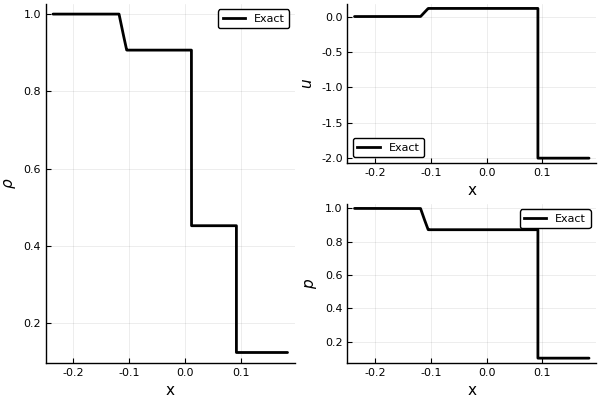

In [36]:
p1 = plot(x,U[:,1], xlabel = "x", ylabel=L" \rho",width =2 ,label = "Exact",color ="black")
p2 = plot(x,U[:,2], xlabel = "x", ylabel=L" u",width =2 ,label = "Exact",color ="black")
p3 = plot(x,U[:,3], xlabel = "x", ylabel=L" p",width =2 ,label = "Exact",color ="black")
l=@layout [a [b;c]]
p = plot(p1,p2,p3,layout=l)

In [30]:
Wₗ = W(10.0,0.0,10.0)
Wᵣ = W(1.25,-2.0,1)
γ = 1.4
#RiemannSolver(Wₗ,Wᵣ,γ)
x,U = SolveDistr(0.1,Wₗ,Wᵣ,γ)

([-0.236643, -0.236052, -0.23546, -0.234868, -0.234277, -0.233685, -0.233094, -0.232502, -0.23191, -0.231319  …  0.179581, 0.180041, 0.180502, 0.180962, 0.181423, 0.181883, 0.182344, 0.182804, 0.183264, 0.183725], [10.0 0.0 10.0; 10.0 0.0 10.0; … ; 1.25 -2.0 1.0; 1.25 -2.0 1.0])

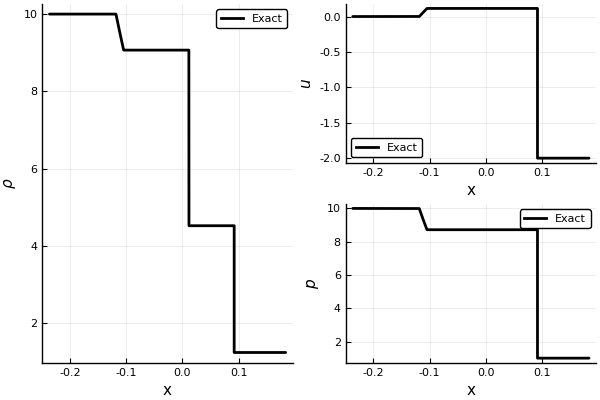

In [31]:
p1 = plot(x,U[:,1], xlabel = "x", ylabel=L" \rho",width =2 ,label = "Exact",color ="black")
p2 = plot(x,U[:,2], xlabel = "x", ylabel=L" u",width =2 ,label = "Exact",color ="black")
p3 = plot(x,U[:,3], xlabel = "x", ylabel=L" p",width =2 ,label = "Exact",color ="black")
l=@layout [a [b;c]]
p = plot(p1,p2,p3,layout=l)

In [13]:
Wₗ = W(1.0,0.0,1000)
Wᵣ = W(1.0,0.0,0.01)
γ = 1.4
#RiemannSolver(Wₗ,Wᵣ,γ)
x,U = SolveDistr(0.1,Wₗ,Wᵣ,γ)

([-7.48331, -7.46461, -7.4459, -7.42719, -7.40848, -7.38977, -7.37107, -7.35236, -7.33365, -7.31494  …  4.58593, 4.59769, 4.60945, 4.62121, 4.63297, 4.64473, 4.65649, 4.66825, 4.68, 4.69176], [1.0 0.0 1000.0; 1.0 0.0 1000.0; … ; 1.0 0.0 0.01; 1.0 0.0 0.01])

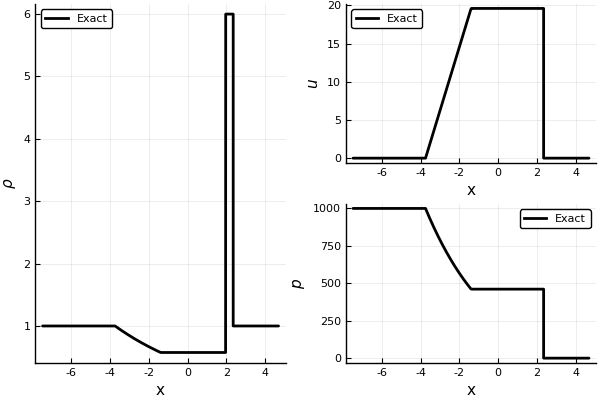

In [14]:
p1 = plot(x,U[:,1], xlabel = "x", ylabel=L" \rho",width =2 ,label = "Exact",color ="black")
p2 = plot(x,U[:,2], xlabel = "x", ylabel=L" u",width =2 ,label = "Exact",color ="black")
p3 = plot(x,U[:,3], xlabel = "x", ylabel=L" p",width =2 ,label = "Exact",color ="black")
l=@layout [a [b;c]]
p = plot(p1,p2,p3,layout=l)

In [15]:
Wₗ = W(1.0,0.0,0.01)
Wᵣ = W(1.0,0.0,100)
γ = 1.4
#RiemannSolver(Wₗ,Wᵣ,γ)
x,U = SolveDistr(0.1,Wₗ,Wᵣ,γ)

([-1.48749, -1.48377, -1.48006, -1.47634, -1.47262, -1.4689, -1.46518, -1.46146, -1.45774, -1.45402  …  2.30727, 2.31319, 2.3191, 2.32502, 2.33094, 2.33685, 2.34277, 2.34868, 2.3546, 2.36052], [1.0 0.0 0.01; 1.0 0.0 0.01; … ; 1.0 0.0 100.0; 1.0 0.0 100.0])

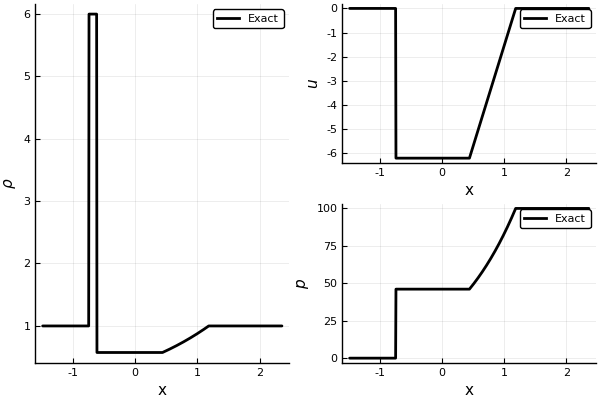

In [15]:
p1 = plot(x,U[:,1], xlabel = "x", ylabel=L" \rho",width =2 ,label = "Exact",color ="black")
p2 = plot(x,U[:,2], xlabel = "x", ylabel=L" u",width =2 ,label = "Exact",color ="black")
p3 = plot(x,U[:,3], xlabel = "x", ylabel=L" p",width =2 ,label = "Exact",color ="black")
l=@layout [a [b;c]]
p = plot(p1,p2,p3,layout=l)

In [1]:
Wₗ = W(1.0,0.0,0.01)
Wᵣ = W(1.0,1.0,0.01)
γ = 1.4
#RiemannSolver(Wₗ,Wᵣ,γ)
x,U = SolveDistr(0.1,Wₗ,Wᵣ,γ)

UndefVarError: UndefVarError: W not defined

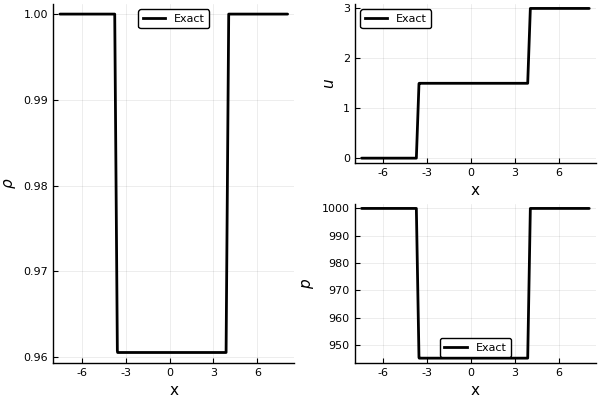

In [16]:
p1 = plot(x,U[:,1], xlabel = "x", ylabel=L" \rho",width =2 ,label = "Exact",color ="black")
p2 = plot(x,U[:,2], xlabel = "x", ylabel=L" u",width =2 ,label = "Exact",color ="black")
p3 = plot(x,U[:,3], xlabel = "x", ylabel=L" p",width =2 ,label = "Exact",color ="black")
l=@layout [a [b;c]]
p = plot(p1,p2,p3,layout=l)

# 制作样本集

In [9]:
pL = 10 .^ (rand(10) .*5 .- 2)   #  0.01 -> 1000
ρR = 10 .^ (rand(10) .*4 .- 2)   # 0.01 -> 10
uR = rand(10) .* 22 .- 20        # -20 -> 3
pR = 10 .^ (rand(10) .*5 .- 2)   

10-element Array{Float64,1}:
 13.378849708979384 
 39.87237466432659  
 37.95860718829306  
  0.9150661293637256
 73.34257660650701  
  6.742774996601847 
 13.388342335811625 
  0.7873050722497447
  0.1005998337776472
  0.5419293260268657

In [396]:
N = 10^3

X = zeros(Float32, (4,N))
X = zeros(Float32, (4,N))
for i in 1:N    
    pL = 10 .^ (rand() .*5 .- 2)   #  0.01 -> 1000
    ρR = 10 .^ (rand() .*4 .- 2)   # 0.01 -> 10
    uR = rand() .* 22 .- 20        # -20 -> 3
    pR = 10 .^ (rand() .*5 .- 2)   
    X[1:4,i ] = [pL,ρR,uR,pR]
end

In [397]:
using BenchmarkTools

In [399]:
#function 
Y = zeros(Float32, (4,N))
γ = 1.4
Wₗ = W(1.0,1.0,1.0)
Wᵣ = W(1.0,1.0,1.0)
for i = 1:N
#i = 1
    Wₗ = W(1.0,0.0,X[1,i])
    Wᵣ = W(X[2,i],X[3,i],X[4,i])
    WₗStar,WᵣStar = RiemannSolver(Wₗ,Wᵣ,γ)
    Y[1,i] = WₗStar.ρ
    Y[2,i] = WᵣStar.ρ
    Y[3,i] =WₗStar.u
    Y[4,i] =WₗStar.p
end

In [11]:
using BSON:@save,@load

In [12]:
using Flux, Flux.Data.MNIST, Statistics
using Flux: onehotbatch, onecold, crossentropy, throttle
using Base.Iterators: repeated
using CuArrays

┌ Warning: Error requiring CuArrays from Flux:
│ LoadError: LoadError: CUDA error: invalid device context (code #201, ERROR_INVALID_CONTEXT)
│ Stacktrace:
│  [1] macro expansion at /home/bfly/.juliapro/JuliaPro_v1.1.1.1/packages/CUDAdrv/lu32K/src/base.jl:147 [inlined]
│  [2] #alloc#3(::CUDAdrv.Mem.CUmem_attach, ::Function, ::Int64, ::Bool) at /home/bfly/.juliapro/JuliaPro_v1.1.1.1/packages/CUDAdrv/lu32K/src/memory.jl:161
│  [3] macro expansion at /home/bfly/.juliapro/JuliaPro_v1.1.1.1/packages/CUDAdrv/lu32K/src/memory.jl:157 [inlined]
│  [4] try_cuda_alloc(::Int64) at /home/bfly/.juliapro/JuliaPro_v1.1.1.1/packages/CuArrays/qZCAt/src/memory.jl:243
│  [5] macro expansion at /home/bfly/.juliapro/JuliaPro_v1.1.1.1/packages/CuArrays/qZCAt/src/memory.jl:302 [inlined]
│  [6] macro expansion at /home/bfly/.juliapro/JuliaPro_v1.1.1.1/packages/TimerOutputs/7zSea/src/TimerOutput.jl:216 [inlined]
│  [7] try_alloc(::Int64, ::Int64) at /home/bfly/.juliapro/JuliaPro_v1.1.1.1/packages/CuArrays/qZCAt/

In [400]:
X = X |> gpu
Y = Y |> gpu

4×1000 CuArray{Float32,2}:
   5.99694    3.20781    0.367977   …   5.93905    5.80574    5.98752
   0.414695   0.0362879  0.361622      41.0842    36.3539   118.081  
 -20.6216    -0.350862   0.494666      -6.97674  -12.7689    -6.34596
 510.397      0.211178   0.0525127     58.6332   198.111     48.3629 

In [360]:
m = Chain(
    Dense(4, 32,σ),
    Dense( 32,64,σ),
    Dense( 64,32,σ),
    Dense(32,4)
    ) |> gpu
    

Chain(Dense(4, 32, NNlib.σ), Dense(32, 64, NNlib.σ), Dense(64, 32, NNlib.σ), Dense(32, 4))

In [378]:
loss(x,y) = sum(abs2,m(x)-y)

loss (generic function with 1 method)

In [401]:
data = Iterators.repeated((X,Y),5000000)

Base.Iterators.Take{Base.Iterators.Repeated{Tuple{CuArray{Float32,2},CuArray{Float32,2}}}}(Base.Iterators.Repeated{Tuple{CuArray{Float32,2},CuArray{Float32,2}}}((Float32[0.0446822 0.032315 … 1.13745 0.017288; 0.430412 0.0175042 … 6.09538 20.0526; -19.0717 -2.37596 … -17.9675 -7.75868; 537.681 0.0724981 … 0.204064 0.157017], Float32[5.99694 3.20781 … 5.80574 5.98752; 0.414695 0.0362879 … 36.3539 118.081; -20.6216 -0.350862 … -12.7689 -6.34596; 510.397 0.211178 … 198.111 48.3629])), 5000000)

In [402]:
opt = ADAM()
#opt = ADADelta()

ADAM(0.001, (0.9, 0.999), IdDict{Any,Any}())

In [381]:
evalcb = () -> @show(loss(X, Y))

#18 (generic function with 1 method)

In [1]:
Flux.train!(loss, Flux.params(m), data, opt, cb = throttle(evalcb, 10))

UndefVarError: UndefVarError: Flux not defined

In [416]:
m = m |> cpu

Chain(Dense(4, 32, NNlib.σ), Dense(32, 64, NNlib.σ), Dense(64, 32, NNlib.σ), Dense(32, 4))

In [417]:
@save "model6_1000.bson" m

In [333]:
@load "model4.bson" m
m

Chain(Dense(4, 64, NNlib.σ), Dense(64, 64, NNlib.σ), Dense(64, 64, NNlib.σ), Dense(64, 64, NNlib.σ), Dense(64, 32, NNlib.σ), Dense(32, 4))

In [411]:
pL = 10 .^ (rand() .*5 .- 2)   #  0.01 -> 1000
ρR = 10 .^ (rand() .*4 .- 2)   # 0.01 -> 10
uR = rand() .* 22 .- 20        # -20 -> 3
pR = 10 .^ (rand() .*5 .- 2) 

A  = [pL; ρR; uR; pR]

4-element Array{Float64,1}:
   0.5478856643642798
   0.6321214282799031
   1.9309052750709483
 220.9427033988297   

In [412]:
m(A)

Tracked 4-element Array{Float32,1}:
  6.088658f0 
  0.4937687f0
 -9.092856f0 
 97.95693f0  

In [413]:
Wₗ = W(1.0, 0.0, pL)
Wᵣ = W(ρR,uR,pR)
γ = 1.4
 WLStar, WRStar = RiemannSolver(Wₗ,Wᵣ,γ)


# 5.99
# 67.16
# -9.92
# 118.33

(W(5.822182894435117, -9.281282171390108, 104.55381969908117), W(0.3704253365940481, -9.281282171390108, 104.55381969908117))

#  Error Test

In [552]:
X_test = zeros(Float32, (4,1000))
Y_test = zeros(Float32, (4,1000))
for i in 1:1000    
    pL = 10 .^ (rand() .*5 .- 2)   #  0.01 -> 1000
    ρR = 10 .^ (rand() .*4 .- 2)   # 0.01 -> 10
    uR = rand() .* 22 .- 20        # -20 -> 3
    pR = 10 .^ (rand() .*5 .- 2)   
    X_test[1:4,i ] = [pL,ρR,uR,pR]
end

In [553]:
#function 
Y_test = zeros(Float32, (4,1000))
γ = 1.4
Wₗ = W(1.0,1.0,1.0)
Wᵣ = W(1.0,1.0,1.0)
for i = 1:1000
#i = 1
    Wₗ = W(1.0,0.0,X[1,i])
    Wᵣ = W(X[2,i],X[3,i],X[4,i])
    WₗStar,WᵣStar = RiemannSolver(Wₗ,Wᵣ,γ)
    Y_test[1,i] = WₗStar.ρ
    Y_test[2,i] = WᵣStar.ρ
    Y_test[3,i] =WₗStar.u
    Y_test[4,i] =WₗStar.p
end

In [40]:
√(0.01/4)

0.05

In [38]:
√(0.004)

0.06324555320336758